In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

import optuna
from sklearn.feature_selection import SelectFromModel, SelectFwe, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import sklearn.metrics as met

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Getting data and Preprocessing

Source: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

In [2]:
data = pd.read_csv('statlog+german+credit+data/german.data', sep=' ', header=None)
columns = ['checking_acc_status', 'duration', 'cred_hist', 'purpose', 'loan_amt', 'saving_acc_bonds',
          'present_employment_since','installment_rate', 'personal_stat_gender', 'other_debtors_guarantors',
          'present_residence_since', 'property', 'age', 'other_installment_plans', 'housing', 'num_curr_loans',
          'job', 'num_people_provide_maint', 'telephone', 'is_foreign_worker', 'target']
df = pd.DataFrame(data.values, columns=columns)
df.head()

,checking_acc_status,duration,cred_hist,purpose,loan_amt,saving_acc_bonds,present_employment_since,installment_rate,personal_stat_gender,other_debtors_guarantors,present_residence_since,property,age,other_installment_plans,housing,num_curr_loans,job,num_people_provide_maint,telephone,is_foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


The categorical columns have been encoded and require replacement with appropriate corresponding values.

In [3]:
mapping_dict = {
    'checking_acc_status': {'A11': 'below_0', 'A12': 'below_200', 'A13': 'above:200', 'A14': 'no_cheking_acc'},
    'cred_hist': {'A30': 'no_loan_or_paid_duly_other', 'A31': 'paid_duly_this_bank', 'A32': 'curr_loans_paid_duly',
                  'A33': 'delay_in_past', 'A34': 'risky_acc_or_curr_loan_other'},
    'purpose': {'A40': 'car_new', 'A41': 'car_used', 'A42': 'furniture_equipment', 'A43': 'radio_tv',
                'A44': 'domestic_applience', 'A45': 'repairs', 'A46': 'education', 'A47': 'vacation',
                'A48': 'retraining', 'A49': 'business', 'A410': 'others'},
    'saving_acc_bonds': {'A61': 'below_100', 'A62': 'below_500', 'A63': 'below_1000', 'A64': 'above_1000',
                         'A65': 'unknown_no_saving_acc'},
    'present_employment_since': {'A71': 'unemployed', 'A72': 'below_1y', 'A73': 'below_4y', 'A74': 'below_7y', 'A75': 'above_7y'},
    'personal_stat_gender': {'A91': 'male:divorced', 'A92': 'female:divorced_or_married', 'A93': 'male:single',
                      'A94': 'male:married_or_widowed', 'A95': 'female:single'},
    'other_debtors_guarantors': {'A101': 'none', 'A102': 'co_applicant', 'A103': 'guarantor'},
    'property': {'A121': 'real_estate', 'A122': 'life_insurance_or_aggreements', 'A123': 'car_or_other',
                 'A124': 'unknown_or_no_property'},
    'other_installment_plans': {'A141': 'bank', 'A142': 'store', 'A143': 'none'},
    'housing': {'A151': 'rent', 'A152': 'own', 'A153': 'for_free'},
    'job': {'A171': 'unemployed_non_resident', 'A172': 'unskilled_resident', 'A173': 'skilled_official',
            'A174': 'management_or_self_emp'},
    'telephone': {'A191': 'no', 'A192': 'yes'},
    'is_foreign_worker': {'A201': 'yes', 'A202': 'no'},
    'target':{1:'good',2:'bad'}
}

df.replace(mapping_dict, inplace=True)
df.head()

,checking_acc_status,duration,cred_hist,purpose,loan_amt,saving_acc_bonds,present_employment_since,installment_rate,personal_stat_gender,other_debtors_guarantors,present_residence_since,property,age,other_installment_plans,housing,num_curr_loans,job,num_people_provide_maint,telephone,is_foreign_worker,target
0,below_0,6,risky_acc_or_curr_loan_other,radio_tv,1169,unknown_no_saving_acc,above_7y,4,male:single,none,4,real_estate,67,none,own,2,skilled_official,1,yes,yes,good
1,below_200,48,curr_loans_paid_duly,radio_tv,5951,below_100,below_4y,2,female:divorced_or_married,none,2,real_estate,22,none,own,1,skilled_official,1,no,yes,bad
2,no_cheking_acc,12,risky_acc_or_curr_loan_other,education,2096,below_100,below_7y,2,male:single,none,3,real_estate,49,none,own,1,unskilled_resident,2,no,yes,good
3,below_0,42,curr_loans_paid_duly,furniture_equipment,7882,below_100,below_7y,2,male:single,guarantor,4,life_insurance_or_aggreements,45,none,for_free,1,skilled_official,2,no,yes,good
4,below_0,24,delay_in_past,car_new,4870,below_100,below_4y,3,male:single,none,4,unknown_or_no_property,53,none,for_free,2,skilled_official,2,no,yes,bad


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking_acc_status       1000 non-null   object
 1   duration                  1000 non-null   object
 2   cred_hist                 1000 non-null   object
 3   purpose                   1000 non-null   object
 4   loan_amt                  1000 non-null   object
 5   saving_acc_bonds          1000 non-null   object
 6   present_employment_since  1000 non-null   object
 7   installment_rate          1000 non-null   object
 8   personal_stat_gender      1000 non-null   object
 9   other_debtors_guarantors  1000 non-null   object
 10  present_residence_since   1000 non-null   object
 11  property                  1000 non-null   object
 12  age                       1000 non-null   object
 13  other_installment_plans   1000 non-null   object
 14  housing                  

All columns are currently assigned the 'object' data type, which occupies more memory space. Numeric columns should be represented as integers or floats, and categorical columns as 'category' types. This optimization would result in more efficient memory storage

In [5]:
numeric_features = ['duration', 'loan_amt', 'installment_rate', 'present_residence_since', 'age', 'num_curr_loans', 
                    'num_people_provide_maint']
categorical_features = ['checking_acc_status', 'cred_hist', 'purpose', 'saving_acc_bonds', 'present_employment_since', 
                        'personal_stat_gender', 'other_debtors_guarantors', 'property', 'other_installment_plans', 
                        'housing', 'job', 'telephone', 'is_foreign_worker']

df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce', downcast='integer')
df[categorical_features] = df[categorical_features].astype('category')
df['target'] = np.where(df['target']=='good', 1, 0).astype('int8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   checking_acc_status       1000 non-null   category
 1   duration                  1000 non-null   int8    
 2   cred_hist                 1000 non-null   category
 3   purpose                   1000 non-null   category
 4   loan_amt                  1000 non-null   int16   
 5   saving_acc_bonds          1000 non-null   category
 6   present_employment_since  1000 non-null   category
 7   installment_rate          1000 non-null   int8    
 8   personal_stat_gender      1000 non-null   category
 9   other_debtors_guarantors  1000 non-null   category
 10  present_residence_since   1000 non-null   int8    
 11  property                  1000 non-null   category
 12  age                       1000 non-null   int8    
 13  other_installment_plans   1000 non-null   categor

In [6]:
for cat in categorical_features:
    print(df[cat].value_counts(1))
    print()

no_cheking_acc    0.394
below_0           0.274
below_200         0.269
above:200         0.063
Name: checking_acc_status, dtype: float64

curr_loans_paid_duly            0.530
risky_acc_or_curr_loan_other    0.293
delay_in_past                   0.088
paid_duly_this_bank             0.049
no_loan_or_paid_duly_other      0.040
Name: cred_hist, dtype: float64

radio_tv               0.280
car_new                0.234
furniture_equipment    0.181
car_used               0.103
business               0.097
education              0.050
repairs                0.022
domestic_applience     0.012
others                 0.012
retraining             0.009
Name: purpose, dtype: float64

below_100                0.603
unknown_no_saving_acc    0.183
below_500                0.103
below_1000               0.063
above_1000               0.048
Name: saving_acc_bonds, dtype: float64

below_4y      0.339
above_7y      0.253
below_7y      0.174
below_1y      0.172
unemployed    0.062
Name: present_employme

In [7]:
df.target.value_counts(1)

1    0.7
0    0.3
Name: target, dtype: float64

In [8]:
X = df[numeric_features+categorical_features] #Independent - predictor variables
y = df['target'] # Dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=19112024, stratify=y)

Train-test split is done to have unseen data in order to check real performance of the model. test_size = 0.25 depicts 25% of dataset will be used as test data, stratify=y ensures proportion of good and bads equal be same in train and test sets

# Baseline Model

![](https://miro.medium.com/v2/resize:fit:837/1*d5-PQyRRjvzBZjI5f7X3hA.png)

In [9]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
X_train_dummies = ohe.fit_transform(X_train[categorical_features])
X_test_dummies = ohe.transform(X_test[categorical_features])
X_train_preprocessed = pd.concat([X_train[numeric_features], X_train_dummies], axis=1)
X_test_preprocessed = pd.concat([X_test[numeric_features], X_test_dummies], axis=1)

model = LogisticRegression(penalty=None, random_state=19112024)
model.fit(X_train_preprocessed, y_train)

# Predict on the test data
y_train_pred_proba = model.predict_proba(X_train_preprocessed)[:, 1]
y_pred_proba = model.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate the model
train_auc = met.roc_auc_score(y_train, y_train_pred_proba)
test_auc = met.roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC on train data: {train_auc}")
print(f"AUC-ROC on test data: {test_auc}")

AUC-ROC on train data: 0.8025142857142857
AUC-ROC on test data: 0.8041904761904761


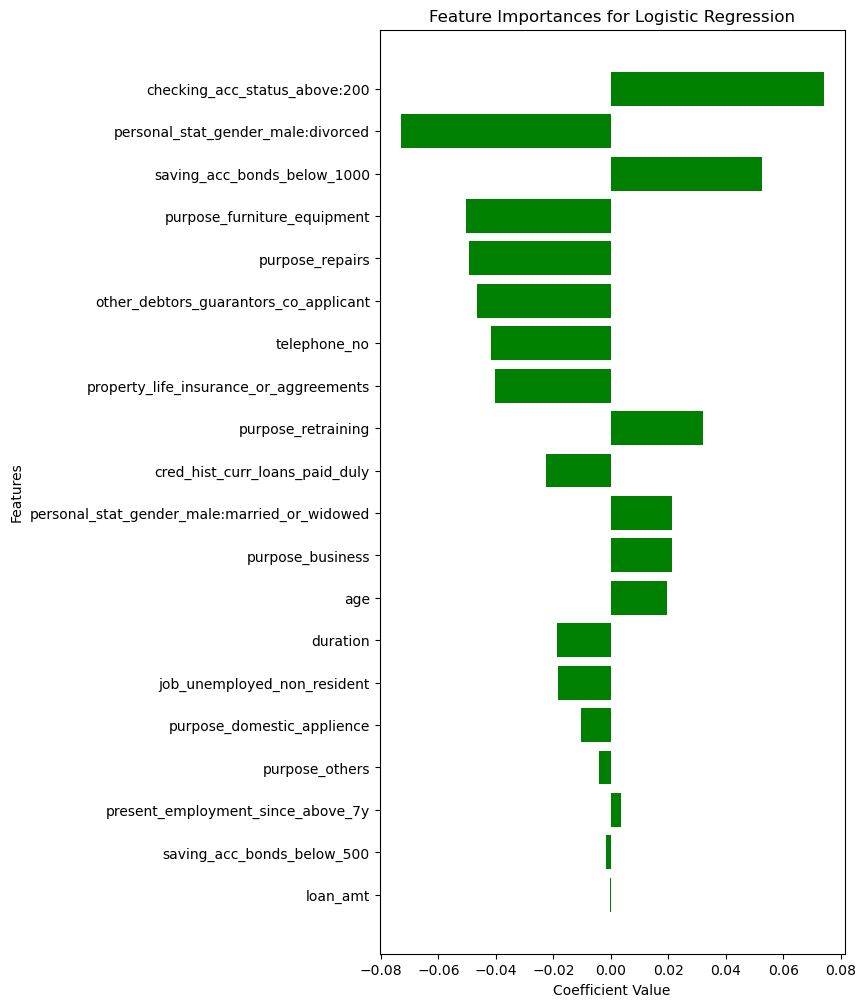

In [10]:
feature_importances = model.coef_[0]
feature_names = list(X_train_preprocessed.columns)
feature_names.append('intercept')

intercept = model.intercept_[0]
fimp = pd.DataFrame(list(feature_importances) + [intercept],
                    index=feature_names, columns=['value']).reset_index()
fimp['significancy'] = fimp.value.abs()
fimp = fimp.sort_values('significancy', ascending=True)

plt.figure(figsize=(6,12))
plt.barh(fimp.iloc[:20]['index'], fimp.iloc[:20]['value'], color='green')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances for Logistic Regression')
plt.show()

# Hyperparameter tuning with Optuna

In [11]:
def objective(trial):
    
    """ 'objective'that takes hyperparameters as input and returns a score to be minimized """
    
    params = {
        'class_weight':'balanced',
        'C': trial.suggest_float("C", 0.001, 1000),
        'l1_ratio': trial.suggest_float("l1_ratio", 0, 1),
        'penalty':'elasticnet',
        'solver': 'saga',
        'random_state': 19112024
    }
    
    min_frequency = trial.suggest_float("min_frequency", 1e-5, 0.04)
    
    numeric_transformer_options = {
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler(),
    }

#     selected_scaler = trial.suggest_categorical("scaler", list(numeric_transformer_options.keys()))
    selected_scaler = trial.suggest_categorical("scaler", ['StandardScaler', 'RobustScaler'])
        
    
    model = LogisticRegression(**params)
    
    cat_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='not_given')), 
                    ('encoder', OneHotEncoder(min_frequency=min_frequency, sparse_output=False, handle_unknown='ignore'))])
    
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                          ('scaler', numeric_transformer_options[selected_scaler])])
    
    # Full Transformer
    transformer = ColumnTransformer(
        transformers=[
            ('cat_p', cat_p, categorical_features),
            ('num_p', numeric_transformer, numeric_features)
        ])


    transformer = ColumnTransformer(transformers=[
        ('cat_p', cat_p, categorical_features), 
        ('num_p', numeric_transformer, numeric_features)
    ], 
    remainder='drop').set_output(transform='pandas')

    
    # Full Pipeline
    pipeline = Pipeline(steps=[
        ('transformer', transformer),
        ('selector2', SelectFromModel(model, max_features=20)),
        ('model', model)
    ]).set_output(transform='pandas')
    

    means = cross_val_score(estimator=pipeline,X=X_train,y=y_train, cv=5, scoring='roc_auc')
    print("Train cv means", means)
    
    
    return np.mean(means)

In [12]:
def tune(objective):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(
                            seed=1))
    study.optimize(objective, n_trials=100, show_progress_bar=True)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return study

In [13]:
study = tune(objective)

[I 2024-01-15 02:06:22,895] A new study created in memory with name: no-name-a28caf47-cc7b-4b2a-8580-ca2d77189bed


  0%|          | 0/100 [00:00<?, ?it/s]

Train cv means [0.72148148 0.75174603 0.71417989 0.70084656 0.71650794]
[I 2024-01-15 02:06:23,304] Trial 0 finished with value: 0.720952380952381 and parameters: {'C': 417.0225876805693, 'l1_ratio': 0.7203244934421581, 'min_frequency': 1.4573848945622016e-05, 'scaler': 'StandardScaler'}. Best is trial 0 with value: 0.720952380952381.
Train cv means [0.70857143 0.74433862 0.72116402 0.74243386 0.71820106]
[I 2024-01-15 02:06:23,643] Trial 1 finished with value: 0.7269417989417989 and parameters: {'C': 92.33950243020304, 'l1_ratio': 0.1862602113776709, 'min_frequency': 0.013828973474451478, 'scaler': 'RobustScaler'}. Best is trial 1 with value: 0.7269417989417989.
Train cv means [0.72148148 0.75174603 0.71417989 0.70084656 0.71703704]
[I 2024-01-15 02:06:23,998] Trial 2 finished with value: 0.7210582010582011 and parameters: {'C': 419.1950952087804, 'l1_ratio': 0.6852195003967595, 'min_frequency': 0.00818604546676338, 'scaler': 'StandardScaler'}. Best is trial 1 with value: 0.7269417989

Train cv means [0.71238095 0.77058201 0.75597884 0.73862434 0.71640212]
[I 2024-01-15 02:06:31,068] Trial 24 finished with value: 0.7387936507936508 and parameters: {'C': 531.1445237948678, 'l1_ratio': 0.8068044139937441, 'min_frequency': 0.027434123761024085, 'scaler': 'RobustScaler'}. Best is trial 17 with value: 0.7395978835978836.
Train cv means [0.69502646 0.74433862 0.72116402 0.7426455  0.71820106]
[I 2024-01-15 02:06:31,382] Trial 25 finished with value: 0.7242751322751323 and parameters: {'C': 727.1206735881634, 'l1_ratio': 0.44649938369386677, 'min_frequency': 0.017964475839679275, 'scaler': 'RobustScaler'}. Best is trial 17 with value: 0.7395978835978836.
Train cv means [0.71322751 0.73777778 0.75174603 0.72169312 0.75089947]
[I 2024-01-15 02:06:31,679] Trial 26 finished with value: 0.735068783068783 and parameters: {'C': 505.19242407783446, 'l1_ratio': 0.9760406562802861, 'min_frequency': 0.025900955132975485, 'scaler': 'StandardScaler'}. Best is trial 17 with value: 0.7395

Train cv means [0.69460317 0.74433862 0.72116402 0.7426455  0.71640212]
[I 2024-01-15 02:06:38,644] Trial 48 finished with value: 0.7238306878306878 and parameters: {'C': 575.2044236314546, 'l1_ratio': 0.7147196567518245, 'min_frequency': 0.02224897559492276, 'scaler': 'RobustScaler'}. Best is trial 17 with value: 0.7395978835978836.
Train cv means [0.71238095 0.77058201 0.75597884 0.7426455  0.71640212]
[I 2024-01-15 02:06:38,970] Trial 49 finished with value: 0.7395978835978836 and parameters: {'C': 493.20181989839676, 'l1_ratio': 0.8024741420438855, 'min_frequency': 0.025614022995778245, 'scaler': 'RobustScaler'}. Best is trial 17 with value: 0.7395978835978836.
Train cv means [0.69460317 0.74433862 0.72116402 0.7426455  0.7184127 ]
[I 2024-01-15 02:06:39,287] Trial 50 finished with value: 0.7242328042328042 and parameters: {'C': 406.1471988724857, 'l1_ratio': 0.9397653682911922, 'min_frequency': 0.019573775844582465, 'scaler': 'RobustScaler'}. Best is trial 17 with value: 0.7395978

Train cv means [0.69460317 0.77058201 0.75597884 0.7426455  0.71640212]
[I 2024-01-15 02:06:46,346] Trial 72 finished with value: 0.736042328042328 and parameters: {'C': 513.8015634298736, 'l1_ratio': 0.6612347653600209, 'min_frequency': 0.024474449783587076, 'scaler': 'RobustScaler'}. Best is trial 17 with value: 0.7395978835978836.
Train cv means [0.71238095 0.77058201 0.75597884 0.73862434 0.71640212]
[I 2024-01-15 02:06:46,660] Trial 73 finished with value: 0.7387936507936508 and parameters: {'C': 639.7987875902963, 'l1_ratio': 0.8023827565166939, 'min_frequency': 0.02684149973701891, 'scaler': 'RobustScaler'}. Best is trial 17 with value: 0.7395978835978836.
Train cv means [0.69460317 0.74433862 0.72116402 0.7426455  0.71820106]
[I 2024-01-15 02:06:46,962] Trial 74 finished with value: 0.7241904761904763 and parameters: {'C': 712.6262903778136, 'l1_ratio': 0.5946460237818025, 'min_frequency': 0.020997028261014905, 'scaler': 'RobustScaler'}. Best is trial 17 with value: 0.739597883

Train cv means [0.71238095 0.77058201 0.75597884 0.7426455  0.71640212]
[I 2024-01-15 02:06:53,850] Trial 96 finished with value: 0.7395978835978836 and parameters: {'C': 676.459500428161, 'l1_ratio': 0.7984995440873057, 'min_frequency': 0.025949464260623223, 'scaler': 'RobustScaler'}. Best is trial 17 with value: 0.7395978835978836.
Train cv means [0.69460317 0.74433862 0.72116402 0.7426455  0.71820106]
[I 2024-01-15 02:06:54,147] Trial 97 finished with value: 0.7241904761904763 and parameters: {'C': 699.1224893509134, 'l1_ratio': 0.8068499155072788, 'min_frequency': 0.02164161828382389, 'scaler': 'RobustScaler'}. Best is trial 17 with value: 0.7395978835978836.
Train cv means [0.71322751 0.73777778 0.75174603 0.7168254  0.75089947]
[I 2024-01-15 02:06:54,440] Trial 98 finished with value: 0.734095238095238 and parameters: {'C': 548.9658602716958, 'l1_ratio': 0.3693265634532306, 'min_frequency': 0.02770898669181899, 'scaler': 'StandardScaler'}. Best is trial 17 with value: 0.739597883

In [14]:
params = study.best_params
params

{'C': 570.8270520415945,
 'l1_ratio': 0.6380393029321028,
 'min_frequency': 0.02643295393743985,
 'scaler': 'RobustScaler'}

In [21]:
model_params = {
    'class_weight': 'balanced',
    'C': params['C'],
   'l1_ratio': params['l1_ratio'],
    'penalty': 'elasticnet',
    'solver': 'saga',
    'random_state': 19112024
}

numeric_transformer_options = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
}

# Logistic Regression model with optimized parameters
model = LogisticRegression(**model_params)

# Preprocessing for categorical features
cat_p = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='not_given')),
    ('encoder', OneHotEncoder(min_frequency=params['min_frequency'], sparse_output=False, handle_unknown='ignore'))
])

# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', numeric_transformer_options[params['scaler']])
])

# Combine transformers
transformer = ColumnTransformer(transformers=[
    ('cat_p', cat_p, categorical_features),
    ('num_p', numeric_transformer, numeric_features)]).set_output(transform='pandas')

# Full pipeline
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('selector2', SelectFromModel(model, max_features=20)),
    ('model', model)
])


# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat_p',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='not_given',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=0.02643295393743985,
                                                                                 sparse_output=False))]),
                                                  ['checking_acc_status',
                                                   'cred_hist', 'purpose',
                                                   'saving_acc_bonds',
                                                   'present_employment_s...
                 SelectFromModel(estimator=LogisticRegression(C=570.8270520415945,
                                                              class_weight='balanced',
                                                              l1_ratio=0.6380393029321028,
                                                              penalty='elasticnet',
                                                              random_state=19112024,
                                                              solver='saga'),
                                 max_features=20)),
                ('model',
                 LogisticRegression(C=570.8270520415945,
                                    class_weight='balanced',
                                    l1_ratio=0.6380393029321028,
                                    penalty='elasticnet', random_state=19112024,
                                    solver='saga'))])

In [16]:
y_train_pred_proba = pipeline.predict_proba(X_train)[:,1]
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

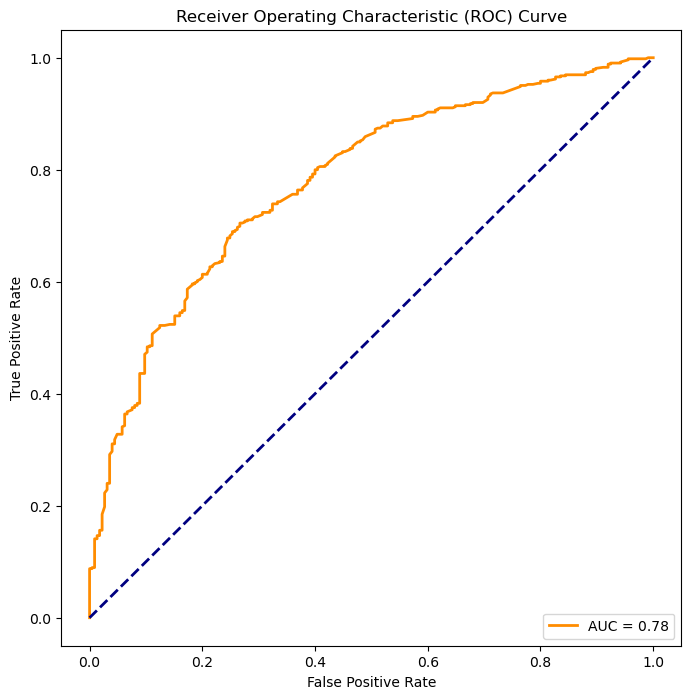

In [22]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = met.roc_curve(y_train, y_train_pred_proba)
roc_auc = met.auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

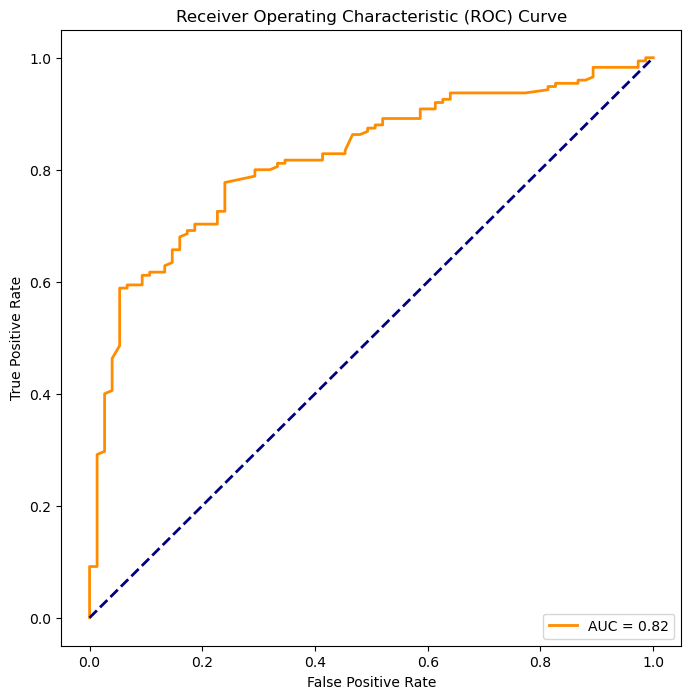

In [23]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = met.roc_curve(y_test, y_pred_proba)
roc_auc = met.auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

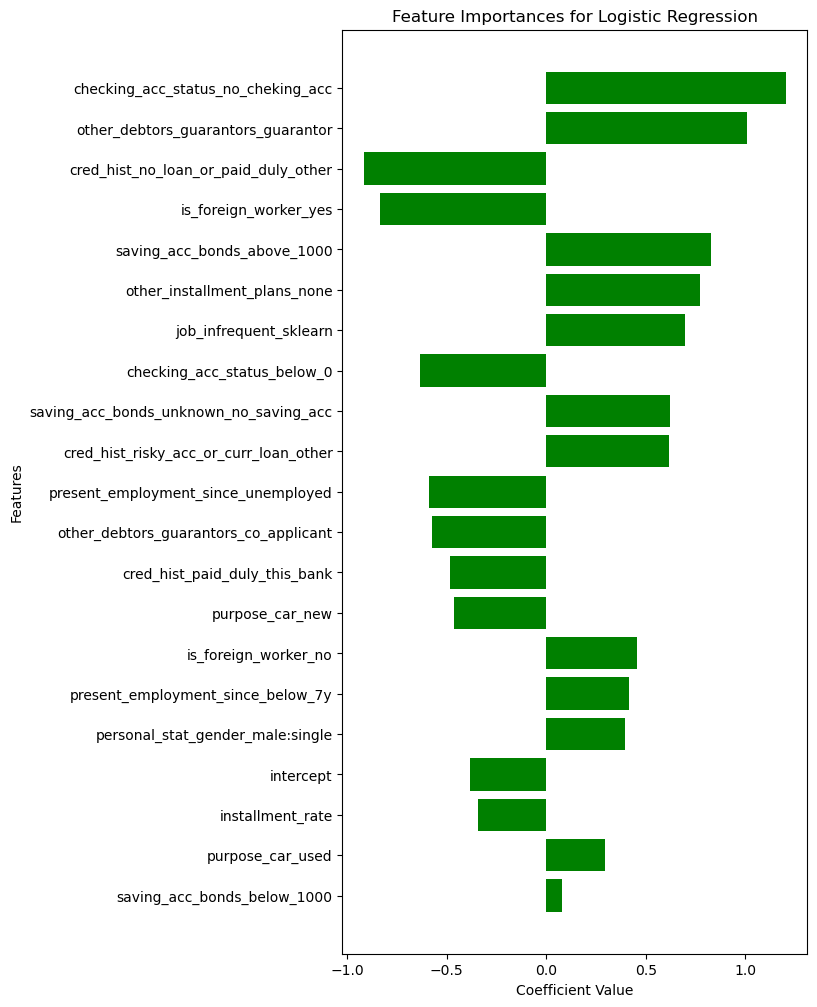

In [41]:
feature_importances = pipeline[-1].coef_[0]
feature_names = pipeline[:-1].get_feature_names_out()
feature_names = ['_'.join(name.split('__')[1:]) for name in feature_names]
feature_names.append('intercept')

intercept = pipeline[-1].intercept_[0]
fimp = pd.DataFrame(list(feature_importances) + [intercept], index=feature_names, columns=['value']).reset_index()
fimp['significancy'] = fimp.value.abs()
fimp = fimp.sort_values('significancy', ascending=True)

plt.figure(figsize=(6,12))
plt.barh(fimp['index'], fimp['value'], color='green')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances for Logistic Regression')
plt.show()